In [1]:
from cpymad.madx import Madx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
from matplotlib.pyplot import cm
from pybt.tools.plotters import *
from pybt.tools.parsers import *
from matplotlib.patches import Ellipse, Rectangle, Arc
import plotly.graph_objs as go
import sys
sys.path.append("/eos/home-e/eljohnso/SWAN_projects/madx-tools")
import importlib
import plot_tool
# importlib.reload(plot_tool)
from plot_tool import *

In [100]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input('''

MBXHD : RBEND, L = 2.5, APERTYPE=RACETRACK, APERTURE={0.0285, 0.0, 0.036, 0.0};
RBEND_CIRCLE : RBEND, L = 2.5, APERTYPE=CIRCLE , APERTURE={0.05};

Q1 : QUADRUPOLE, L = 1.0, K1=0.01, APERTYPE=CIRCLE , APERTURE={0.1};

B1 : MBXHD, ANGLE := kBHZ4, TILT=-0.0;
B2 : RBEND_CIRCLE, ANGLE := kBHZ4, TILT=-0.0;
B3 : RBEND_CIRCLE, ANGLE := kBHZ4, TILT=-0.0, APERTYPE=CIRCLE , APERTURE={0.05};

kBHZ4 = -0.03492;


my_seq: SEQUENCE, refer = exit, l = 20;
B1 : B1, AT=4;
B2 : B2, AT=8;
Q1 : Q1, AT=12;
B3 : B3, AT=18;
ENDSEQUENCE;


BEAM, PARTICLE = PROTON, PC = 24, EXN = 4.92e-06, EYN=3.4e-06;
BRHO      := BEAM->PC * 3.3356;
SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L, DELTAP, BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;

USE, SEQUENCE =  my_seq;
TWISS, BETX=154, ALFX=-36.9, BETY=5.22, ALFY=0.252, DX=0.13, DPX=0.02, DY=0.0, DPY=0.0, DELTAP=0.0;

''')

twiss = madx.table["twiss"].dframe()

############################## CREATE PARTICLES DISTRIBUTION ##############################

number_of_particles = 200
# Random distributions
x = np.random.normal(0, 0.01, number_of_particles)
xp = np.random.normal(0, 0.001, number_of_particles)
y = np.random.normal(0, 0.01, number_of_particles)
yp = np.random.normal(0, 0.001, number_of_particles)
pt = np.random.normal(0, 0.1, number_of_particles)

init_dist = np.column_stack((x, xp, y, yp, pt))

In [101]:
madx.input('''
USE, SEQUENCE = my_seq;
PTC_CREATE_UNIVERSE;
PTC_CREATE_LAYOUT, MODEL = 1, METHOD = 2, EXACT = FALSE, NST = 4;
PTC_OBSERVE, PLACE = b1;
PTC_OBSERVE, PLACE = b2;
''')

# madx.input("PTC_START, X = 0.03, PX = 0.002, Y = 0.00, PY = 0.000, PT=0.1")
for particle in init_dist:
    madx.input(f'PTC_START, X= {particle[0]}, px={particle[1]}, y={particle[2]}, py={particle[3]}, pt={particle[4]};')
    
madx.input('''
PTC_TRACK, TURNS=1, ICASE=5, ELEMENT_BY_ELEMENT=TRUE, DUMP=FALSE, ONETABLE=TRUE, RECLOSS=TRUE, CLOSED_ORBIT=FALSE, MAXAPER={100,100,100,100,100,100};
PTC_TRACK_END;
''')

ptc_output = madx.table.trackone.dframe()
ptc_lost = madx.table.trackloss.dframe()

In [102]:
# Particles that are lost but with full trace
d = {'number': [], 'turn': [], 'x': [], 'px': [], 'y': [], 'py': [], 't': [], 'pt': [], 's': [], 'e': []}
ptc_lost_traces = pd.DataFrame(data=d)

for number in ptc_lost.number.unique():
    df_lost = ptc_lost.where(ptc_lost.number==number).dropna()
    df = ptc_output.where(ptc_output.number==number).dropna()
    df = pd.concat([df,df_lost])
    ptc_lost_traces = pd.concat([ptc_lost_traces, df])
ptc_lost_traces.reset_index(drop=True, inplace=True)

(-0.2, 0.2)

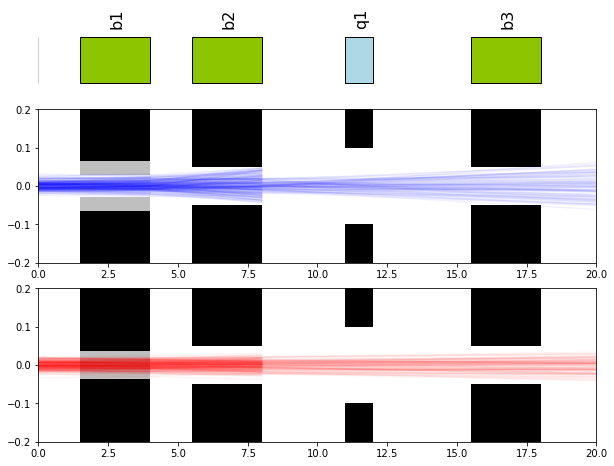

In [103]:
fig, ax = plt.subplots(3,1, figsize=(10, 8), height_ratios=[1,2,2])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

for i in range(int(number_of_particles)):
    i=i+1

    ax[1].plot(ptc_output[ptc_output.number == i].s, ptc_output[ptc_output.number == i].x, color="b", alpha=0.05)
    ax[2].plot(ptc_output[ptc_output.number == i].s, ptc_output[ptc_output.number == i].y, color="r", alpha=0.05)

draw_aperture_rectcircle(ax[1], ax[2], twiss,"aper_1", "aper_2", "aper_3")
draw_aperture_racetrackH(ax[1], twiss,"aper_1", "aper_2", "aper_3","aper_4")
draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")

draw_aperture_racetrackV(ax[2], twiss,"aper_1", "aper_2", "aper_3","aper_4")
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")

ax[1].set_xlim(0,twiss.s[-1])
ax[2].set_xlim(0,twiss.s[-1])
ax[1].set_ylim(-0.2, 0.2)
ax[2].set_ylim(-0.2, 0.2)

In [104]:
fig, ax = plt.subplots(figsize=(10,10))

s = 4

x = ptc_lost.where(ptc_lost.s == s).dropna().x
y = ptc_lost.where(ptc_lost.s == s).dropna().y

ax.scatter(x,y, alpha=1, label="lost")

x = ptc_output.where(ptc_output.s == s).dropna().x
y = ptc_output.where(ptc_output.s == s).dropna().y

ax.scatter(x,y, alpha=0.5, label="not lost")

draw_MCB_aperture(ax, 28.5/1000, 36/1000, 36/1000)

ax.set_aspect("equal")
ax.legend()

In [106]:
fig = go.Figure()


# Draw particles

particle_nums = ptc_output['number'].unique()
for particle_num in particle_nums:
    df = ptc_output[ptc_output['number'] == particle_num]
    fig.add_trace(go.Scatter3d(x=df['s'],
                               y=df['x'],
                               z=df['y'],
                               mode='lines',
                               opacity=0.5,
                               line=dict(width=1),
                               marker=dict(size=5, color="blue")))
    
particle_nums = ptc_lost_traces['number'].unique()
for particle_num in particle_nums:
    df = ptc_lost_traces[ptc_lost_traces['number'] == particle_num]
    fig.add_trace(go.Scatter3d(x=df['s'],
                               y=df['x'],
                               z=df['y'],
                               mode='lines',
                               opacity=0.5,
                               line=dict(width=1),
                               marker=dict(size=5, color="red")))

fig.add_trace(go.Scatter3d(x=ptc_lost['s'],
                               y=ptc_lost['x'],
                               z=ptc_lost['y'],
                   mode='markers',
                   marker=dict(size=2, color='red')))
    
    
    
# Build the geomtry of the line

for index in twiss.where(twiss.keyword== "rbend").dropna().index:
    aper_1 = twiss.loc[index].aper_1
    aper_3 = twiss.loc[index].aper_3
    if twiss.loc[index].apertype == "circle":
        aper_3 = aper_1
        aper_1 = 0.0
    x,y,z,i,j,k = mesh_beam_element(aper_1, aper_3, twiss.loc[index].l, twiss.loc[index].s)
    fig.add_trace(go.Mesh3d(
            x=z,
            y=x,
            z=y,
            opacity=0.5,
            color="lightgreen",
            i = i,
            j = j,
            k = k,
    ))
    
for index in twiss.where(twiss.keyword== "quadrupole").dropna().index:
    aper_1 = twiss.loc[index].aper_1
    aper_3 = twiss.loc[index].aper_3
    if twiss.loc[index].apertype == "circle":
        aper_3 = aper_1
        aper_1 = 0.0
    x,y,z,i,j,k = mesh_beam_element(aper_1, aper_3, twiss.loc[index].l, twiss.loc[index].s)
    fig.add_trace(go.Mesh3d(
            x=z,
            y=x,
            z=y,
            opacity=0.5,
            color="cyan",
            i = i,
            j = j,
            k = k,
    ))
    
fig.update_layout(scene=dict(xaxis_title='S Axis Label',
                              yaxis_title='X Axis Label',
                              zaxis_title='Y Axis Label',
                              aspectmode='auto',
                             xaxis=dict(range=[0, twiss.s.max()]),
                             yaxis=dict(range=[-0.15, 0.15]),
                              zaxis=dict(range=[-0.15, 0.15])),
                             width=2000,
                              height=1000)

fig.show()

In [108]:
import plotly.offline as pyo
pyo.iplot(fig, show_link=False, link_text=False, config={'displayModeBar': False})